In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import json

In [45]:
class TurbidMediaDataset(Dataset):
    def __init__(self, histograms, irfs, ups, ua):
        self.histograms = histograms
        self.irfs = irfs
        self.ups = ups
        self.ua = ua

    def __len__(self):
        return len(self.histograms)

    def __getitem__(self, idx):
        histogram = torch.tensor(self.histograms[idx], dtype=torch.float32).unsqueeze(0) # Add channel dimension
        irf = torch.tensor(self.irfs[idx], dtype=torch.float32).unsqueeze(0) # Add channel dimension
        ups = torch.tensor(self.ups[idx], dtype=torch.float32)
        ua = torch.tensor(self.ua[idx], dtype=torch.float32)
        return histogram, irf, ups, ua

# Custom Exp Layer Module
class ExpLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.exp(x)

class OpticalPropertiesEstimator(nn.Module):
    def __init__(self, config): # Config dictionary as input
        super(OpticalPropertiesEstimator, self).__init__()
        self.config = config # Store config

        # CNN branch for Histogram
        hist_cnn_layers = []
        in_channels = 1 # Input channels for the first CNN layer
        cnn_filters_hist = config.get('cnn_filters_hist', [16, 32, 64]) # Convolutional neural network filter sizes
        kernel_size_cnn = config.get('kernel_size_cnn', 3) # Convolutional kernel size
        pool_size_cnn = config.get('pool_size_cnn', 2) # Pooling size
        padding_cnn = config.get('padding_cnn', 1) # Padding size
        use_batchnorm_cnn = config.get('use_batchnorm_cnn', True) # Configurable batch norm

        for out_channels in cnn_filters_hist:
            hist_cnn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size_cnn, padding=padding_cnn)) # 1D Convolutional layer
            if use_batchnorm_cnn:
                hist_cnn_layers.append(nn.BatchNorm1d(out_channels)) # Batch norm layer
            hist_cnn_layers.append(nn.ReLU())  # ReLU activation
            hist_cnn_layers.append(nn.MaxPool1d(pool_size_cnn))  # Max pooling
            in_channels = out_channels
        self.hist_cnn = nn.Sequential(*hist_cnn_layers)

        # CNN branch for IRF (similar structure to hist_cnn)
        irf_cnn_layers = []
        in_channels = 1
        cnn_filters_irf = config.get('cnn_filters_irf', [16, 32, 64]) # Default filter sizes for IRF CNN
        for out_channels in cnn_filters_irf:
            irf_cnn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size_cnn, padding=padding_cnn)) # 1D Convolutional layer
            if use_batchnorm_cnn:
                irf_cnn_layers.append(nn.BatchNorm1d(out_channels)) # Batch norm layer
            irf_cnn_layers.append(nn.ReLU()) # ReLU activation
            irf_cnn_layers.append(nn.MaxPool1d(pool_size_cnn)) # Max pooling
            in_channels = out_channels
        self.irf_cnn = nn.Sequential(*irf_cnn_layers)

        # Calculate flattened size after CNN layers by running a tryal forward pass
        example_input = torch.randn(1, 1, 4096) # Dummy input for size calculation
        hist_cnn_output_size = self._get_cnn_output_size(self.hist_cnn, example_input)
        irf_cnn_output_size = self._get_cnn_output_size(self.irf_cnn, example_input)
        combined_cnn_output_size = hist_cnn_output_size + irf_cnn_output_size

        # Fully connected layers with BatchNorm
        fc_layers = []
        fc_layer_sizes = config.get('fc_layer_sizes', [128, 64]) # Default FC layer sizes
        dropout_rate_fc = config.get('dropout_rate_fc', 0.2) # Configurable dropout
        in_features = combined_cnn_output_size

        for layer_size in fc_layer_sizes:
            fc_layers.append(nn.Linear(in_features, layer_size)) # Fully connected layer
            fc_layers.append(nn.BatchNorm1d(layer_size)) # Batch norm layer
            fc_layers.append(nn.ReLU()) # ReLU activation
            fc_layers.append(nn.Dropout(dropout_rate_fc)) # Dropout layer
            in_features = layer_size
        fc_layers.append(nn.Linear(in_features, 2)) # Output layer (ups and ua)
        fc_layers.append(ExpLayer()) # Ensure positive output using Exponential activation
        self.fc = nn.Sequential(*fc_layers)


    def _get_cnn_output_size(self, cnn_layers, input_tensor):
        '''
        Helper function to calculate the output size after custom CNN layers
        '''
        output = cnn_layers(input_tensor)
        return int(np.prod(output.size()[1:])) # Return flattened size

    def forward(self, histogram, irf):
        hist_features = self.hist_cnn(histogram)
        hist_features = hist_features.view(hist_features.size(0), -1) # Flatten
        irf_features = self.irf_cnn(irf)
        irf_features = irf_features.view(irf_features.size(0), -1) # Flatten
        combined_features = torch.cat((hist_features, irf_features), dim=1)
        output = self.fc(combined_features)
        return output

# Custom MSE Loss with UA Weight
class MSELossWeightedUA(nn.Module):
    def __init__(self, ua_weight=1.0): # Add ua_weight as a parameter, default to 1.0
        super().__init__()
        self.ua_weight = ua_weight

    def forward(self, predictions, targets):
        # No need to clamp predictions here as ExpLayer ensures positivity
        # Targets are assumed to be positive or non-negative

        squared_error = (predictions - targets)**2

        # Separate errors for ups and ua
        ups_error = squared_error[:, 0] # Error for ups (first output)
        ua_error = squared_error[:, 1]  # Error for ua (second output)

        # Apply weight to ua error
        weighted_ua_error = self.ua_weight * ua_error

        # Combine the losses (sum and then average)
        loss = torch.mean(ups_error + weighted_ua_error)

        return loss

In [46]:
best_network_config = {'cnn_filters_hist': [16, 32, 128, 256, 1024],
                       'cnn_filters_irf': [32, 128, 256, 512],
                       'kernel_size_cnn': 20,
                       'pool_size_cnn': 2,
                       'padding_cnn': 1,
                       'use_batchnorm_cnn': True,
                       'fc_layer_sizes': [1024, 512, 256, 128, 32],
                       'dropout_rate_fc': 0.0,
                       'lr': 0.002,
                       'step_size': 10,
                       'gamma': 0.8,
                       'batch_size': 64,
                       'ua_weight': 300.0,
                       'clip_grad': 1.0,
                       'patience': 100}

config_path = 'TrainedModels/optical_propierties_estimator_config.json'

with open(config_path, 'w') as f:
    json.dump(best_network_config, f, indent=4) 

In [47]:
trained_model = OpticalPropertiesEstimator(best_network_config)
with open(config_path, 'r') as f:
    best_network_config = json.load(f)

In [48]:
model_path = 'TrainedModels/optical_properties_estimator_weights.pth'
trained_model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)

OpticalPropertiesEstimator(
  (hist_cnn): Sequential(
    (0): Conv1d(1, 16, kernel_size=(20,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(20,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 128, kernel_size=(20,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(128, 256, kernel_size=(20,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [49]:
import os

# Iterate through each file in the folder SIMs that starts with sim_results_

# First extract the suffix from the filename so they are loaded in the same order
sim_runs = []
for filename in os.listdir('SIMs'):
    if filename.startswith('sim_results_'):
        suffix = filename.split('_')[-1] # Extract the suffix
        sim_runs.append(suffix)

histograms_data = []
for suffix in sim_runs:
    filename = 'sim_results_' + suffix
    file_path = os.path.join('SIMs', filename)
    histograms_data.append(np.load(file_path))

histograms_data = np.concatenate(histograms_data, axis=0) # Concatenate all histograms
histograms_data =  np.array(histograms_data, dtype=np.float32) # Convert to float32


irfs_data = []
for suffix in sim_runs:
    filename = 'sim_irfs_' + suffix
    file_path = os.path.join('SIMs', filename)
    irfs_data.append(np.load(file_path))

irfs_data = np.concatenate(irfs_data, axis=0) # Concatenate all IRFs
irfs_data = np.array(irfs_data, dtype=np.float32) # Convert to float32


tags_data = []
for suffix in sim_runs:
    filename = 'sim_tags_' + suffix
    file_path = os.path.join('SIMs', filename)
    tags_data.append(np.load(file_path))

tags_data = np.concatenate(tags_data, axis=0) # Concatenate all tags
tags_data = np.array(tags_data, dtype=np.float32) # Convert to float32


ua_data = tags_data[:, 0] # Extract ups
ups_data = tags_data[:, 1] # Extract ua

print(len(ua_data))
print(ua_data)
print(ups_data)

8000
[0.01494949 0.01494949 0.00808081 ... 0.00646465 0.01010101 0.01010101]
[1.98 1.98 1.   ... 1.76 1.1  1.1 ]


In [50]:
## 2. Split data into training and validation sets
histograms_train, histograms_val, irfs_train, irfs_val, ups_train, ups_val, ua_train, ua_val = train_test_split(
    histograms_data, irfs_data, ups_data, ua_data, test_size=0.2, random_state=42
)

# 3. Create Datasets and DataLoaders
batch_size = 128

train_dataset = TurbidMediaDataset(histograms_train, irfs_train, ups_train, ua_train)
val_dataset = TurbidMediaDataset(histograms_val, irfs_val, ups_val, ua_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [51]:
#    Load a sample histogram and IRF (e.g., from your validation set or a new measurement)
sample_index = 5 # Example index from validation set
sample_histogram = torch.tensor(histograms_val[sample_index], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
sample_irf = torch.tensor(irfs_val[sample_index], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

trained_model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_optical_properties = trained_model(sample_histogram, sample_irf)

predicted_ups = predicted_optical_properties[0][0].item()
predicted_ua = predicted_optical_properties[0][1].item()
actual_ups = ups_val[sample_index]
actual_ua = ua_val[sample_index]

print(f"Predicted ups: {predicted_ups:.4f}, Actual ups: {actual_ups:.4f}")
print(f"Predicted ua: {predicted_ua:.4f}, Actual ua: {actual_ua:.4f}")

Predicted ups: 0.3518, Actual ups: 0.3200
Predicted ua: 0.0104, Actual ua: 0.0089


/tmp/ipykernel_24003/247300303.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  error_ua.append(abs((actual_ua - predicted_ua)/actual_ua)*100)


Median error in ups:  3.2883525
Median error in ua:  4.5981092


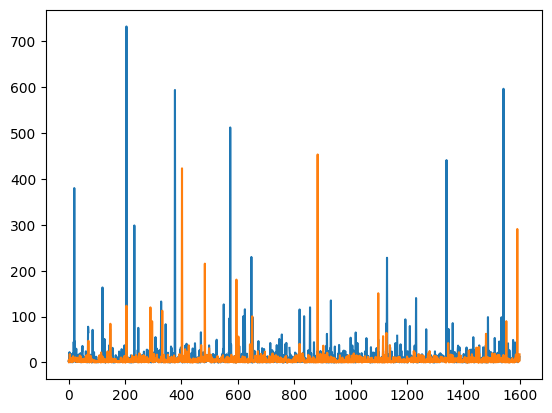

In [52]:
error_ua = []
error_ups = []
actual_uas = []
actual_upss = []

for i in range(len(histograms_val)):
    sample_histogram = torch.tensor(histograms_val[i], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
    sample_irf = torch.tensor(irfs_val[i], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

    trained_model.eval() # Set model to evaluation mode
    with torch.no_grad():
        predicted_optical_properties = trained_model(sample_histogram, sample_irf)

    predicted_ups = predicted_optical_properties[0][0].item()
    predicted_ua = predicted_optical_properties[0][1].item()
    actual_ups = ups_val[i]
    actual_ua = ua_val[i]

    actual_uas.append(actual_ua)
    actual_upss.append(actual_ups)

    error_ua.append(abs((actual_ua - predicted_ua)/actual_ua)*100)
    error_ups.append(abs((actual_ups - predicted_ups)/actual_ups)*100)
    

print("Median error in ups: ", np.nanmedian(error_ups))
print("Median error in ua: ", np.nanmedian(error_ua))

plt.plot(error_ua, label='Error in ua')
plt.plot(error_ups, label='Error in ups')

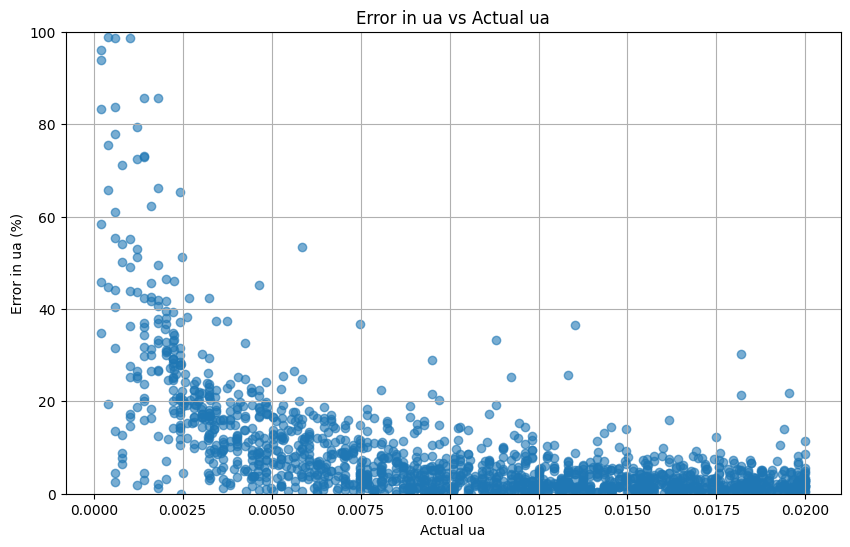

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_uas, error_ua, alpha=0.6)
plt.xlabel('Actual ua')
plt.ylabel('Error in ua (%)')
plt.ylim(0, 100)
plt.title('Error in ua vs Actual ua')
plt.grid(True)
plt.show()

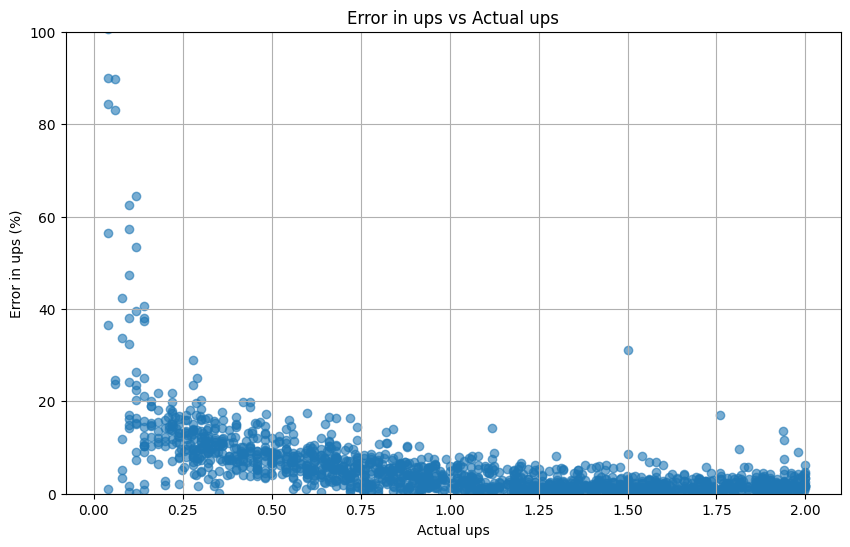

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_upss, error_ups, alpha=0.6)
plt.xlabel('Actual ups')
plt.ylabel('Error in ups (%)')
plt.ylim(0, 100)
plt.title('Error in ups vs Actual ups')
plt.grid(True)
plt.show()